I downloaded the bioinformatics files from the [stackexchange archives](https://archive.org/download/stackexchange) and pulled out the 'Posts.xml' file, renaming it to 'bioinformatics_Posts.xml'.

In [1]:
import os
xml_files = [f for f in os.listdir() if f.endswith('xml')]
xml_files

['bioinformatics_Posts.xml']

In [2]:
import xml.etree.ElementTree as ET
import html # for html.unescape()
import re
from bs4 import BeautifulSoup # for soup.get_text()
import pandas as pd

def safe_unescape(html_raw):
    if str(type(html_raw)) == "<class 'NoneType'>":
        html_raw = ''
    return html.unescape(html_raw)


def list_tags(tags_str):
    return ';'.join(tags_str[1:-1].split('><'))


def get_html_text(html_raw):
    html_str = safe_unescape(html_raw)
    soup = BeautifulSoup(html_str, 'html.parser')
    html_txt = soup.get_text()
    return html_txt


In [3]:
def extract_posts(xml_file):
    topic = xml_file.split('_')[0]
    row_count = 0

    with open(xml_file, encoding='utf-8') as xml_file_handle:
        csv_file = xml_file.replace('.xml', '.csv')
        # print(csv_file)
        data_rows = []
        for line in xml_file_handle:
                if re.match('  <row ', line):
                    row_count += 1
                    row_root = ET.fromstring(line)

                    title = get_html_text( row_root.attrib.get('Title') )
                    body = get_html_text( row_root.attrib.get('Body') )
                    tags = list_tags(safe_unescape( row_root.attrib.get('Tags') ) )
                    last_activity_date = row_root.attrib.get('LastActivityDate')
                    row_dict = {
                        'topic':topic, 
                        'title':title, 
                        'body':body,
                        'text': title + ': ' + body,
                        'tags':tags, 
                        'last_activity_date':last_activity_date,
                    }
                    if (len(row_dict['tags']) > 0):
                        data_rows.append(row_dict)
                
        return pd.DataFrame(data_rows) #.to_csv(csv_file, index=False)


In [4]:
post_data = extract_posts('bioinformatics_Posts.xml')
# post_data.to_csv('bioinformatics_posts.csv', index=False)
post_data

/var/folders/4t/7982ncgx1271113b4hlqb9jr0000gn/T/ipykernel_23535/2722553304.py:19: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  soup = BeautifulSoup(html_str, 'html.parser')


,topic,title,body,text,tags,last_activity_date
0,bioinformatics,What's the most efficient file format for the ...,I'd like to learn which format is most commonl...,What's the most efficient file format for the ...,human-genome|storage|file-formats,2022-02-23T16:01:18.060
1,bioinformatics,Accuracy of the original human DNA datasets se...,The Human Genome Project was the project of 'd...,Accuracy of the original human DNA datasets se...,hgp|phylogenetics,2017-12-28T11:43:48.257
2,bioinformatics,Mapping drug names to ATC codes,I'm interested working with the medication inf...,Mapping drug names to ATC codes: I'm intereste...,drugs|ontology,2017-05-16T19:36:42.037
3,bioinformatics,What are the optimal parameters for docking a ...,I'm looking to dock a large ligand (~90kDa) to...,What are the optimal parameters for docking a ...,proteins|docking,2017-05-18T00:01:22.427
4,bioinformatics,"What is the difference between FASTA, FASTQ, a...",I'd like to learn the differences between 3 co...,"What is the difference between FASTA, FASTQ, a...",fasta|fastq|file-formats|sam,2022-08-18T18:58:12.410
...,...,...,...,...,...,...
6088,bioinformatics,How to do post hoc comparisons after a repeate...,I have a data set of several samples with thei...,How to do post hoc comparisons after a repeate...,statistics|modelling|graphs|lme4,2024-04-01T17:10:57.933
6089,bioinformatics,How do I get the gene annotations as a text fi...,Also posted on biostars\nI have a genbank file...,How do I get the gene annotations as a text fi...,gene|sequence-annotation,2024-03-29T17:59:05.480
6090,bioinformatics,"I'm trying to run aTRAM tool for assembly, but...",Code:\n$ python3 atram.py --max-processes=12 \...,"I'm trying to run aTRAM tool for assembly, but...",ngs|assembly,2024-04-04T20:50:57.923
6091,bioinformatics,Dante Labs VCF: UPDATE: SOLVED,Has anyone tried to analyse the VCF files prov...,Dante Labs VCF: UPDATE: SOLVED: Has anyone tri...,assembly|chromosomes,2024-03-30T15:55:38.210


In [5]:
# %pip install sentence-transformers

import os.path

PARQUET_FILE = 'bioinformatics_posts_feaurized.parquet'

if os.path.exists(PARQUET_FILE):
    post_data = pd.read_parquet(PARQUET_FILE)
else:
    from sentence_transformers import SentenceTransformer
    sentxformer = SentenceTransformer('sentence-transformers/all-mpnet-base-v2')
    post_data['vector'] = sentxformer.encode(post_data['text'].values).tolist()
    post_data.to_parquet(PARQUET_FILE)

In [6]:
post_data

,topic,title,body,text,tags,last_activity_date,vector
0,bioinformatics,What's the most efficient file format for the ...,I'd like to learn which format is most commonl...,What's the most efficient file format for the ...,human-genome|storage|file-formats,2022-02-23T16:01:18.060,"[0.014872616156935692, -0.0047749062068760395,..."
1,bioinformatics,Accuracy of the original human DNA datasets se...,The Human Genome Project was the project of 'd...,Accuracy of the original human DNA datasets se...,hgp|phylogenetics,2017-12-28T11:43:48.257,"[0.04468059539794922, 0.06568889319896698, -0...."
2,bioinformatics,Mapping drug names to ATC codes,I'm interested working with the medication inf...,Mapping drug names to ATC codes: I'm intereste...,drugs|ontology,2017-05-16T19:36:42.037,"[-0.010394892655313015, 0.026336176320910454, ..."
3,bioinformatics,What are the optimal parameters for docking a ...,I'm looking to dock a large ligand (~90kDa) to...,What are the optimal parameters for docking a ...,proteins|docking,2017-05-18T00:01:22.427,"[-0.0013415450230240822, -0.06368420273065567,..."
4,bioinformatics,"What is the difference between FASTA, FASTQ, a...",I'd like to learn the differences between 3 co...,"What is the difference between FASTA, FASTQ, a...",fasta|fastq|file-formats|sam,2022-08-18T18:58:12.410,"[0.008551211096346378, -0.1012071967124939, 0...."
...,...,...,...,...,...,...,...
6088,bioinformatics,How to do post hoc comparisons after a repeate...,I have a data set of several samples with thei...,How to do post hoc comparisons after a repeate...,statistics|modelling|graphs|lme4,2024-04-01T17:10:57.933,"[-0.02073032222688198, -0.041035693138837814, ..."
6089,bioinformatics,How do I get the gene annotations as a text fi...,Also posted on biostars\nI have a genbank file...,How do I get the gene annotations as a text fi...,gene|sequence-annotation,2024-03-29T17:59:05.480,"[-0.018143154680728912, -0.06433402746915817, ..."
6090,bioinformatics,"I'm trying to run aTRAM tool for assembly, but...",Code:\n$ python3 atram.py --max-processes=12 \...,"I'm trying to run aTRAM tool for assembly, but...",ngs|assembly,2024-04-04T20:50:57.923,"[0.007657384965568781, -0.04133884236216545, -..."
6091,bioinformatics,Dante Labs VCF: UPDATE: SOLVED,Has anyone tried to analyse the VCF files prov...,Dante Labs VCF: UPDATE: SOLVED: Has anyone tri...,assembly|chromosomes,2024-03-30T15:55:38.210,"[0.031339049339294434, -0.06817580759525299, 0..."


In [7]:
len(post_data['vector'][0])


768

# Predicting Tags

## Embedding Features

In [8]:
X_df = pd.DataFrame([ v for v in post_data['vector']], columns=[f"x{i:03d}" for i in range(768)])
X_df

,x000,x001,x002,x003,x004,x005,x006,x007,x008,x009,...,x758,x759,x760,x761,x762,x763,x764,x765,x766,x767
0,0.014873,-0.004775,-0.007195,-0.034233,-0.059395,-0.007482,0.013200,0.056657,-0.018833,-0.014939,...,-0.072727,-0.021658,0.008866,-0.043742,-0.000096,0.078150,0.027665,-0.037105,-0.012692,-0.032466
1,0.044681,0.065689,-0.007328,-0.013621,-0.038573,-0.004548,-0.005284,0.059338,-0.035645,0.018142,...,-0.001476,0.007047,-0.040007,0.038169,0.016837,0.078260,-0.015438,-0.052276,-0.005270,-0.011646
2,-0.010395,0.026336,-0.007965,-0.003505,0.008722,0.035524,0.007279,0.050938,0.046614,0.023035,...,-0.000784,0.009792,0.065352,0.046750,-0.006140,0.005928,0.014048,-0.018507,-0.066493,-0.028611
3,-0.001342,-0.063684,0.033235,-0.040546,-0.004611,-0.049212,0.038368,-0.019623,0.068239,-0.004146,...,-0.059507,0.029703,-0.015472,0.012447,0.017360,-0.019005,0.001535,-0.003331,-0.022716,0.007137
4,0.008551,-0.101207,0.002317,-0.017980,0.006839,0.014880,0.044906,-0.033286,-0.055779,-0.037281,...,0.007461,0.018055,-0.000602,-0.028298,-0.046191,0.005864,0.052111,-0.056488,0.004680,0.011089
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6088,-0.020730,-0.041036,-0.000983,0.068210,0.009278,-0.032402,-0.000517,0.019554,0.017665,0.004764,...,-0.040969,0.031341,0.016514,0.035058,-0.006194,0.010269,-0.000069,-0.003999,-0.032147,-0.035864
6089,-0.018143,-0.064334,0.007197,0.044644,-0.016114,0.037837,-0.046999,0.030417,0.047653,-0.044890,...,-0.028131,-0.013696,0.057823,0.025601,-0.026332,-0.018100,0.025028,-0.062797,-0.023498,-0.016434
6090,0.007657,-0.041339,-0.026319,-0.054222,0.058259,0.073278,0.052221,0.037345,0.000933,0.013832,...,0.035261,-0.011293,0.058293,-0.003422,0.027383,-0.024553,-0.009098,0.033980,-0.122632,-0.056123
6091,0.031339,-0.068176,0.005704,-0.022599,-0.046011,0.043816,-0.022325,0.019917,-0.048498,-0.016807,...,0.004089,0.003037,-0.043993,-0.001819,-0.012292,0.019014,0.003193,-0.026956,-0.069155,-0.004879


## Binary Labels

In [9]:
from collections import Counter

tag_lists  =[tag_string.split('|') for tag_string in post_data['tags']]

all_tags = []
for tag_list in tag_lists:
    all_tags.extend(tag_list)

tag_counter = Counter(all_tags)

keeper_tags = [tag for tag, cnt in tag_counter.items() if cnt > 30]

tag_flags = { tag: [tag in tag_list for tag_list in tag_lists ] for tag in keeper_tags }

flags_df = pd.DataFrame(tag_flags)

flags_df


,human-genome,file-formats,phylogenetics,proteins,docking,fasta,fastq,sam,sequence-alignment,bwa,...,virus,limma,proteomics,bash,genetics,correlation,bcftools,wgcna,nextflow,multiple-sequence-alignment
0,True,True,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1,False,False,True,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
3,False,False,False,True,True,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
4,False,True,False,False,False,True,True,True,False,False,...,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6088,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
6089,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
6090,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
6091,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


## Train Classifiers

In [10]:
from sklearn.linear_model import LogisticRegressionCV
from sklearn.model_selection import train_test_split
import numpy as np
from sklearn import metrics

X_train, X_test, flags_train, flags_test = train_test_split(
    X_df, flags_df, test_size=1/4, random_state=42)

models = {}
for tag in flags_train.columns:
    clf = LogisticRegressionCV(cv=5, random_state=0).fit(X_train, flags_train[tag])
    scores_test = clf.predict_proba(X_test)
    fpr, tpr, thresholds = metrics.roc_curve(flags_test[tag], scores_test[:,1]) # scores_test, pos_label=2)
    auc = metrics.roc_auc_score(flags_test[tag], scores_test[:,1])
    npos = np.sum(flags_test[tag]),
    models[tag] = {'tag': tag, 'clf': clf, 'npos': npos[0], 'auc': auc, 'fpr': fpr, 'tpr': tpr}

<Axes: xlabel='npos', ylabel='auc'>

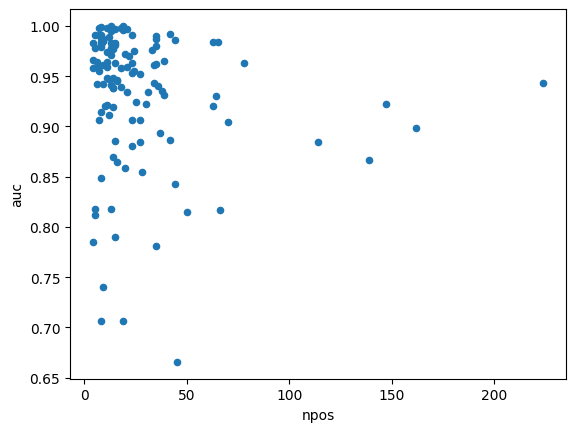

In [11]:
pd.DataFrame([ {'tag': model['tag'], 'npos': model['npos'], 'auc': model['auc'] } for model in models.values()] ).plot.scatter(x='npos', y='auc')

(array([ 1.,  0.,  0.,  0.,  2.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,
         1.,  2.,  0.,  0.,  2.,  3.,  0.,  0.,  2.,  1.,  2.,  2.,  1.,
         4.,  2.,  4.,  2.,  7.,  2.,  8.,  9.,  6., 13.,  4., 12., 16.,
        12.]),
 array([0.66575013, 0.67410638, 0.68246262, 0.69081887, 0.69917512,
        0.70753137, 0.71588761, 0.72424386, 0.73260011, 0.74095635,
        0.7493126 , 0.75766885, 0.76602509, 0.77438134, 0.78273759,
        0.79109383, 0.79945008, 0.80780633, 0.81616257, 0.82451882,
        0.83287507, 0.84123131, 0.84958756, 0.85794381, 0.86630005,
        0.8746563 , 0.88301255, 0.89136879, 0.89972504, 0.90808129,
        0.91643753, 0.92479378, 0.93315003, 0.94150627, 0.94986252,
        0.95821877, 0.96657501, 0.97493126, 0.98328751, 0.99164375,
        1.        ]),
 <BarContainer object of 40 artists>)

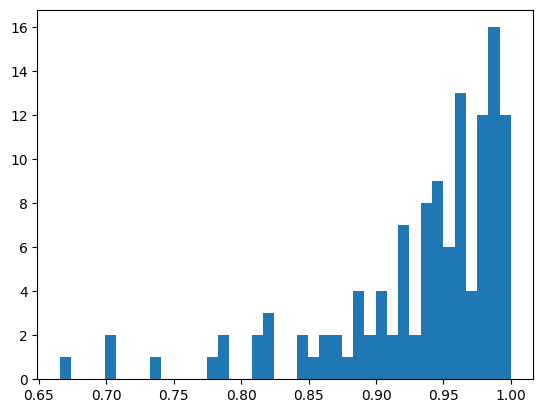

In [12]:
model_auc = [ (tag, model_info['auc']) for tag, model_info in models.items() ]

import matplotlib.pyplot as plt

plt.hist([x[1] for x in model_auc], bins=40)


In [16]:
clf = models['human-genome']['clf']
scores_test = clf.predict_proba(X_test)
print(scores_test)

most_positive_idx = np.argmax(scores_test[:,1])

scores_test[most_positive_idx,]

[[0.99255787 0.00744213]
 [0.99255801 0.00744199]
 [0.99255718 0.00744282]
 ...
 [0.99255897 0.00744103]
 [0.99255883 0.00744117]
 [0.99255955 0.00744045]]


array([0.99255493, 0.00744507])

In [14]:
len(clf.coef_[0]) # 768

768

## Extract Coefficients

In [32]:
def get_model_data(my_models):
    import numpy as np


    def get_vector_length(v):
        return np.sum(v**2)


    def to_unit_vector(v):
        return v/get_vector_length(v)


    targets = []
    intercepts = []
    beta_scaling_factors = []
    beta_unit_vectors = []
    for k, d in my_models.items():
        clf = d['clf']
        targets.append(k)
        intercepts.append(clf.intercept_)
        v_coef = clf.coef_[0]
        beta_scaling_factors.append( get_vector_length(v_coef))
        beta_unit_vectors.append( to_unit_vector(v_coef))

    return pd.DataFrame({
        'target':targets, 
        'intercept': intercepts, 
        'beta_scaling_factor': beta_scaling_factors,
        'beta_unit_vector': beta_unit_vectors
    })

model_data = get_model_data(models)

model_data.to_parquet('stackoverflow_bioinformatics_model_data.parquet')

model_data

,target,intercept,beta_scaling_factor,beta_unit_vector
0,human-genome,[-4.893155415765397],7.060725e-07,"[29.04572836097266, 34.07822273996583, 7.73876..."
1,file-formats,[-4.297905012610927],1.491027e-06,"[24.769423219930818, -44.054902236842985, 14.6..."
2,phylogenetics,[-3.154366395243298],3.684912e+02,"[-0.0009742893197140286, 0.00231832631760786, ..."
3,proteins,[-3.2345828185294754],2.448587e-05,"[0.1546846283244423, -3.206515020571791, 7.951..."
4,docking,[-6.826442570497323],8.059266e+02,"[-0.0003429361444801781, -0.003335007621728146..."
...,...,...,...,...
116,correlation,[-5.089278866889584],9.779384e-07,"[-23.74924073719046, 35.63132674498599, -13.92..."
117,bcftools,[-8.69740195659524],6.593444e+02,"[-0.0019922082193849057, -0.000735313614939927..."
118,wgcna,[-8.215119669220732],6.055970e+02,"[-0.0011876914230189175, 0.0007642744949000313..."
119,nextflow,[-8.971010045629072],5.965656e+02,"[0.0009204207199477518, 0.0009349354126072984,..."
